# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [88]:
PATH = "./data/"

In [89]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [90]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [91]:
## number of males and females overall
gender_grouped = data.groupby('Sex')['Name'].count()
gender_grouped

Sex
female    314
male      577
Name: Name, dtype: int64

In [92]:
## proportion of males and females overall 
males_rate = gender_grouped['male']*100/data.shape[0]
females_rate = gender_grouped['female']*100/data.shape[0]
print(f'Proportions overall: males: {males_rate:.2f}%, females: {females_rate:.2f}%')

Proportions overall: males: 64.76%, females: 35.24%


In [93]:
## number of males and females among survivors
data_survivors = data[data.Survived == 1]
gender_survivors_grouped = data_survivors.groupby('Sex')['Name'].count()
gender_survivors_grouped

Sex
female    233
male      109
Name: Name, dtype: int64

In [94]:
## proportion of males and females among survivors 
males_survived_rate = gender_survivors_grouped['male']*100/data_survivors.shape[0]
females_survived_rate = gender_survivors_grouped['female']*100/data_survivors.shape[0]
print(f'Proportions among survivors: males: {males_survived_rate:.2f}%, females: {females_survived_rate:.2f}%')

Proportions among survivors: males: 31.87%, females: 68.13%


#### Analysis
Originally there were almost twice as many males as females. However, among survivors the number of females is more than 2x larger than males (which means that a lot more females survived compared to males). Therefore, sex is an importan feature for predicting survival.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

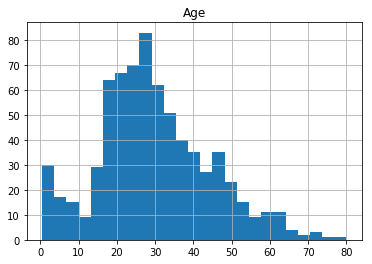

In [95]:
## Age distribution of the passengers
data.hist(column='Age', bins=25)
plt.show()

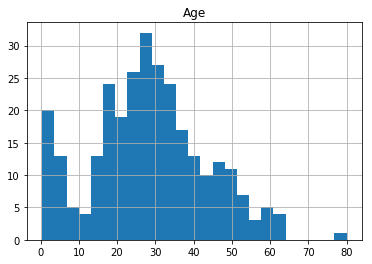

In [96]:
## Age distribution for survived passengers 
data_survivors.hist(column='Age', bins=25)
plt.show()


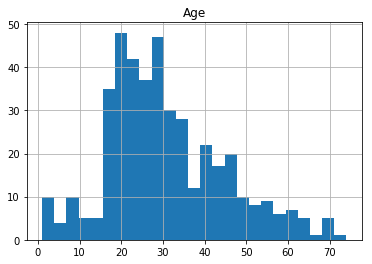

In [97]:
## Age distribution for deceased passengers 
data_deceased = data[data.Survived == 0]
data_deceased.hist(column='Age', bins=25)
plt.show()


< your thoughts >

In [98]:
## Average age: survived and deceased 
print(f'Average age: survived passengers - {data_survivors.Age.mean():.2f}, \
deceased passengers - {data_deceased.Age.mean():.2f}')


Average age: survived passengers - 28.34, deceased passengers - 30.63


In [99]:
## Median age: survived and deceased 
print(f'Median age: survived passengers - {data_survivors.Age.median():.2f}, \
deceased passengers - {data_deceased.Age.median():.2f}')

Median age: survived passengers - 28.00, deceased passengers - 28.00


#### Analysis
Median age of survived and deceased passenders does not differ, but mean age of decceased passengers is slightly higher. This means that the distribution of deceased passengers is skewed to the right (most values are grouped in the left part). In other words, younger people tended to help others and save older people. At the same time, we can see that Age feature has only a moderate impact on predicting survival.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

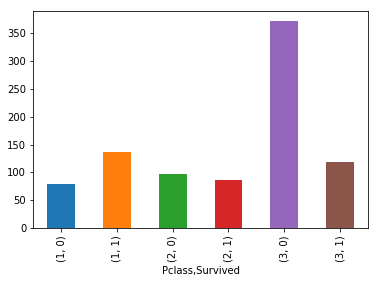

In [100]:
## passenger class: survived and deceased 
data.groupby(by = ['Pclass', 'Survived'])['Name'].count().plot(kind='bar');

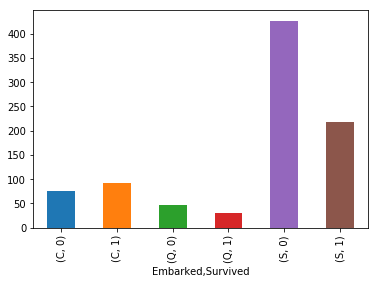

In [101]:
## embarkation port: survived and deceased 
data.groupby(by = ['Embarked', 'Survived'])['Name'].count().plot(kind='bar');

#### Analysis
Survival rates among classes are different. First class survived most, so it is the safest. Second class had almost 50/50 survivors and deceased. Third class was the most dangerous, as the majority of people there were deceased :( 
Overall, class is a valid classification feature for predicting survival.
As for embarkation port, it can also be a valid prediction feature. Survival for port C is higher than non-survival. The number of deceased for port O is comparable with the number of survivors. Port S destination is assocated with low chances of survival. Thus, embarkation port can also be used as a model feature. 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [102]:
## % of missing values for each feature
data.isna().sum()*100/data.shape[0]

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Analysis
There are missing data for: Age, Cabin and Embarked. Cabin describes cabin number, and most likely has no reasoanble value for modeling (so we can drop this column). This is a radical way to deal with missing values, but in this case it is acceptable. 

Another way to handle missing data is dropping the rows with missing data. For example, we can drop the rows where Embarked is missing (only 0.22% of records). The advantage of the method: it is fast and does not add bias. The disadvantage: train set is reduced in size. This method is only applicable when there are a few rows with missing data, and the dataset is large.

Missing data can also be imputed with most frequent value (e.g. mean or median). This method is relatively fast. However, it does not take into account other features, and may add more noise to the model. Alternatively, missing values can be imputed using a regression or classification model, using other features. This is an efficient way but it requires more computing power, and may be an overkill in many cases. 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [228]:
## we will take the following features: Sex, Age, Pclass, Embarked, Sibsp, Parch
selected_features = ['Sex', 'Age', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Survived']
x = data[selected_features]

In [229]:
## handle missing values

def handle_missing_data(df):
    updated_df = df.copy()
    ## drop records with missing Embarked data 
    updated_df = updated_df[updated_df.Embarked.isna() == False]
    ## fill missing Age values with median age 
    updated_df.fillna(updated_df.median(), inplace=True)
    updated_df.reset_index(drop=True, inplace=True)
    return updated_df

In [230]:
x = handle_missing_data(x)

In [232]:
## handle categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

def process_categorical_data(df):
    cat_columns = ['Sex', 'Pclass', 'Embarked']
    updated_df = df.copy()
    df_cat = updated_df[cat_columns]
    ## apply one hot encoding 
    ohe_encoded_df_cat = encoder.fit_transform(df_cat).toarray()
    encoded_df_cat = pd.DataFrame(ohe_encoded_df_cat, columns=encoder.get_feature_names())
    # encoded_df_cat.index = encoded_df_cat.index + 1
    ## add included categorical variables to the dataframe
    ## default values would be: Sex - female, Pclass - 1, Embarked - C
    df_col_names = ['sex_male', 'pclass_2', 'pclass_3', 'embarked_Q', 'embarked_S']
    encoded_df_col_names = ['x0_male', 'x1_2','x1_3', 'x2_Q', 'x2_S']
    updated_df[df_col_names] = encoded_df_cat[encoded_df_col_names]
    updated_df.drop(cat_columns, axis=1, inplace=True)
    return updated_df

In [233]:
x = process_categorical_data(x)

In [238]:
from sklearn.model_selection import cross_validate

y = x['Survived']
x.drop('Survived', axis=1, inplace=True)

In [248]:
## logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(max_iter = 150)
lr.fit(x,y)
cv_accuracy = cross_val_score(lr, x, y, cv=10, scoring = 'accuracy').mean()
print(f'Cross-validation accuracy score for logistic regression: {cv_accuracy:.4f}')

Cross-validation accuracy score: 0.7998


In [255]:
## KNN
from sklearn.neighbors import KNeighborsClassifier
num_clusters = 3
knn = KNeighborsClassifier(n_neighbors = num_clusters)
knn.fit(x, y)
cv_accuracy = cross_val_score(knn, x, y, cv=10, scoring = 'accuracy').mean()
print(f'Cross-validation accuracy score for KNN with k={num_clusters}: {cv_accuracy:.4f}')

Cross-validation accuracy score for KNN with k=3: 0.7818


## Analysis 
We have found that for the given set of features logistic regression with default hyperparameters produces accuracy of **0.7998**, and KNN classification with k=3 yields accuracy of **0.7818**. Both models are relatively good, but logistic regression yields a bi higher accuracy. 

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [259]:
## additional features
## Let's create a column IsAlone with 1 for those traveling without parents, children, siblings and spouses
x['IsAlone'] = x.apply(lambda r: 1 if r.SibSp == 0 and r.Parch == 0 else 0, axis=1) 
## Let's create a column IsWithOnePartner with 1 for those traveling with only one partner 
x['IsWithOnePartner'] = x.apply(lambda r: 1 if r.SibSp == 1 and r.Parch == 0 else 0, axis=1) 

In [262]:
## updated logistic regression 
lr = LogisticRegression(max_iter = 150)
lr.fit(x,y)
cv_accuracy = cross_val_score(lr, x, y, cv=10, scoring = 'accuracy').mean()
print(f'Cross-validation accuracy score for logistic regression: {cv_accuracy:.4f}')

Cross-validation accuracy score for logistic regression: 0.7998


In [266]:
## updated KNN
num_clusters = 3
knn = KNeighborsClassifier(n_neighbors = num_clusters)
knn.fit(x, y)
cv_accuracy = cross_val_score(knn, x, y, cv=10, scoring = 'accuracy').mean()
print(f'Cross-validation accuracy score for KNN with k={num_clusters}: {cv_accuracy:.4f}')

Cross-validation accuracy score for KNN with k=3: 0.7650


In [269]:
## experiment with cluster number
k_range = range(1,10)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x, y)
    cv_accuracy = cross_val_score(knn, x, y, cv=10, scoring = 'accuracy').mean()
    scores.append(cv_accuracy)
scores
## maximal accuracy is still reached for num_clusters = 3

[0.7288559754851889,
 0.7581716036772217,
 0.7649770173646578,
 0.7480720122574055,
 0.7526046986721144,
 0.7356996935648621,
 0.7436287027579163,
 0.7311797752808988,
 0.741317671092952]

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [291]:
## read test data
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [277]:
## apply preprocessing
selected_features_test = ['Sex', 'Age', 'Pclass', 'Embarked', 'SibSp', 'Parch']
x_test = data_test[selected_features_test]
x_test = handle_missing_data(x_test)
x_test = process_categorical_data(x_test)
x_test['IsAlone'] = x_test.apply(lambda r: 1 if r.SibSp == 0 and r.Parch == 0 else 0, axis=1) 
x_test['IsWithOnePartner'] = x_test.apply(lambda r: 1 if r.SibSp == 1 and r.Parch == 0 else 0, axis=1) 

In [294]:
## predict
y_pred = lr.predict(x_test)
output = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': y_pred})

In [296]:
# generate output
output_path = os.path.join(PATH, 'titanic', 'submission.csv')
output.to_csv(output_path, index = False)

## kaggle name: ladyirony
## kaggle results: 0.77272


## Screenshot of Kaggle results 
https://github.com/OlgaGnatenko/rsschool-ml/blob/task5/kaggle_1.png
https://github.com/OlgaGnatenko/rsschool-ml/blob/task5/kaggle_2.png

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

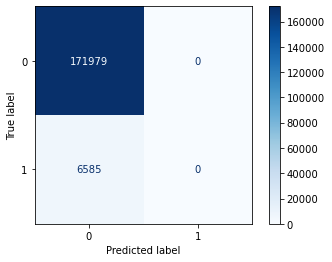

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

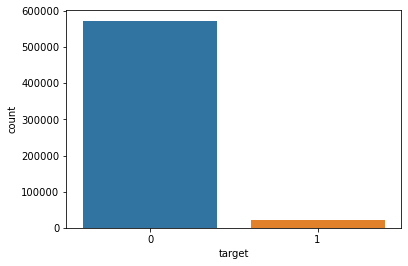

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code